__Классификация по тональности__

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.

In [ ]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [ ]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:33, 2155.24it/s]


In [ ]:
responses[575]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Спасибо Тодуа Георгию',
 'num_comments': 1,
 'bank_license': 'лицензия № 2289',
 'author': 'tatyana1309',
 'bank_name': 'Русский Стандарт',
 'datetime': '2015-05-27 15:40:00',
 'text': 'В начале мая я открывала вклад в банке Русский Стандарт на ст.м. "Тимирязевская". Мои средства ошибочно были зачислены на чужой счёт. Ошибку первыми заметили в банке, и мне сразу позвонили и сказали, что нужно придти к ним в отделение и написать соответствующее заявление на возврат средств. Заявление принимал Тодуа Георгий. И хотя ситуация с моими деньгами на чужом банковском счёте сама по себе была далеко не приятной, а время ожидания, когда мой вопрос решится в мою пользу, казалось бесконечным, именно благодаря Георгию я не впадала в панику. Конечно, я не могла просто сидеть и ждать, когда денежки ко мне вернутся, поэтому я довольно часто приходила в отделение банка с вопросом "Когда?", и Георгий всякий раз спокойно и дружелюбно выяснял, н

# Часть 1. Анализ текстов

## 1. Посчитайте количество отзывов в разных городах и на разные банки

In [ ]:
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [ ]:
df.shape

(153499, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [ ]:
df.isna().sum() # смотрим пропуски

city                  15174
rating_not_checked        0
title                     0
num_comments              0
bank_license              1
author                   20
bank_name                 0
datetime                  0
text                      0
rating_grade          64841
dtype: int64

In [ ]:
df.bank_name.nunique() # количество уникальных банков

670

In [ ]:
df.city.nunique() # количество уникальных городов

5823

In [ ]:
df.bank_name.value_counts(dropna=False).sort_index() # кол-во вхождений по банкам с сортировкой по алфавиту

2Т Банк          655
АБ Финанс         23
АББ                2
АМБ Банк           1
АМТ Банк         142
                ... 
Юнистрим          81
ЯР-Банк           12
Яндекс.Деньги    226
Ярославич          5
Ярсоцбанк          7
Name: bank_name, Length: 670, dtype: int64

In [ ]:
sorted(df.bank_name.unique()) # смотрим банки "глазами"

['2Т Банк',
 'АБ Финанс',
 'АББ',
 'АМБ Банк',
 'АМТ Банк',
 'АФ Банк',
 'Абсолют Банк',
 'Авангард',
 'Аверс',
 'Автоградбанк',
 'Автоторгбанк',
 'Агропромкредит',
 'Агророс',
 'Агросоюз',
 'Агрохимбанк',
 'Адамон Банк',
 'Адмиралтейский',
 'Азиатско-Тихоокеанский Банк',
 'Ай-Си-Ай-Си-Ай Банк (ICICI)',
 'АйМаниБанк',
 'Айви Банк',
 'Ак Барс',
 'Академический Русский Банк',
 'Акибанк',
 'Аксонбанк',
 'АктивКапитал Банк',
 'Акцент',
 'Акцепт',
 'Алданзолотобанк',
 'Александровский',
 'Алеф-Банк',
 'Алмазэргиэнбанк',
 'Алтынбанк',
 'Альта-Банк',
 'Альфа-Банк',
 'Анелик РУ',
 'Анкор Банк',
 'Анталбанк',
 'Арксбанк',
 'Аспект',
 'ББР Банк',
 'БИНБАНК кредитные карты',
 'БКС — Инвестиционный Банк',
 'БМВ Банк',
 'БНП Париба Банк',
 'БСТ-Банк',
 'БФГ-Кредит',
 'БайкалБанк',
 'БайкалИнвестБанк',
 'Байкалкредобанк',
 'Балтийский Банк',
 'Балтика',
 'Балтинвестбанк',
 'Банк «МБА-Москва»',
 'Банк «Санкт-Петербург»',
 'Банк АВБ',
 'Банк БКФ',
 'Банк БФА',
 'Банк БФТ',
 'Банк БЦК-Москва',
 'Банк В

На мой взгляд, с названиями банков всё в порядке. Встречается "задвоенность" (например, ВТБ - ВТБ 24 - ВТБ Северо-Запад). В целом, названия банков можно оставить в таком виде.

In [ ]:
df.city.value_counts(dropna=False).sort_index(ascending=True) # кол-во вхождений по городам с сортировкой по алфавиту и учётом None

г.  (Красногорск)                              1
г.  (Москва)                                   2
г.  (Россия)                                   1
г.  (Ханты-Мансийский автономный округ)        1
г. -                                           1
                                           ...  
г. янаул                                       2
г. ярославль                                  12
г. ярцево                                      2
г. … или другой населенный пункт               1
None                                       15174
Name: city, Length: 5824, dtype: int64

Названия городов требуют обработки. Много пропущенных значений, скобки и т.п.

In [ ]:
#!pip install natasha
# natasha — это библиотека для извлечения именованных сущностей на основе Yargy-парсера и CRF, плюс некоторое количество предобученных моделей,
# например, для извлечения имен.

In [ ]:
#!pip install natasha<1 yargy<0.13 # Чтобы использовать старый NamesExtractor, AddressExtactor понизьте версию pip install natasha<1 yargy<0.13

/bin/bash: 1: No such file or directory


In [ ]:
!pip install "natasha<1" "yargy<0.13"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.9/777.9 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 107.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=18b3d8d26379160da4a5e23f85377764307f89d695825055f3e5f3336df9bfaa
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


In [ ]:
from natasha import LocationExtractor

In [ ]:
def extract_city(text):
    if isinstance(text, str):
        extractor = LocationExtractor()
        matches = extractor(text)
        if len(matches) > 0:
            return matches[0].fact.name
        else:
            return None
    else:
        return None

In [ ]:
df['city_copy_1'] = df['city'].map(extract_city)

In [ ]:
df.head(1)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,city_copy_1
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,москва


In [ ]:
df[['city','city_copy_1']].head(20)

,city,city_copy_1
0,г. Москва,москва
1,г. Новосибирск,новосибирск
2,г. Москва,москва
3,г. Ставрополь,ставрополь
4,г. Челябинск,челябинск
5,г. Москва,москва
6,г. Волгоград,волгоград
7,г. Москва,москва
8,г. Пермь,пермь
9,г. Ростов-на-Дону,ростов


In [ ]:
print(df.city.nunique()) # количество уникальных городов ДО обработки
print('________________')
print(df.city_copy_1.nunique()) # количество уникальных городов ПОСЛЕ обработки

5823
________________
1532


In [ ]:
df.city_copy_1.value_counts(dropna=False).sort_index(ascending=True) # кол-во вхождений по городам с сортировкой по алфавиту и учётом None

абаз             2
абакан         109
абашево          2
абдулино         1
абинск           8
             ...  
ясногорск        2
яхрома           3
яшкино           1
ёсаратов         1
None         18419
Name: city_copy_1, Length: 1533, dtype: int64

In [ ]:
print(df.city.isna().sum()) # пропуски в городах ДО обработки
print('----------')
print(df.city_copy_1.isna().sum()) # # пропуски в городах ПОСЛЕ обработки

15174
----------
18419


In [ ]:
print('Если удалим все пропуски по городам, то потеряем', round(100-((153499-18419)/153499)*100), '%, это чуть больше допустимых 10%')

Если удалим все пропуски по городам, то потеряем 12 %, это чуть больше допустимых 10%


In [ ]:
df=df.drop(['city'], axis=1) # удалили не нужные далее столбцы

In [ ]:
df_=df.dropna(subset=['city_copy_1'], axis=0) # удалили пропуски
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135080 entries, 0 to 138946
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   rating_not_checked  135080 non-null  bool   
 1   title               135080 non-null  object 
 2   num_comments        135080 non-null  int64  
 3   bank_license        135079 non-null  object 
 4   author              135079 non-null  object 
 5   bank_name           135080 non-null  object 
 6   datetime            135080 non-null  object 
 7   text                135080 non-null  object 
 8   rating_grade        73151 non-null   float64
 9   city_copy_1         135080 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.4+ MB


In [ ]:
sorted(df_.city_copy_1.unique()) # смотрим обработанные города "глазами"

['абаз',
 'абакан',
 'абашево',
 'абдулино',
 'абинск',
 'абинский район',
 'авсюнино',
 'агалатовое',
 'агаповка',
 'агидель',
 'агинское',
 'агрыз',
 'адлер',
 'адыгея',
 'азнакаево',
 'азнакаевский район',
 'азов',
 'академгородок',
 'аксай',
 'аксаковое',
 'актау',
 'алабушево',
 'алания',
 'алапаевск',
 'алатырь',
 'алдан',
 'алейск',
 'александр',
 'александровск',
 'алексеевка',
 'алексин',
 'алматы',
 'алтайск',
 'алтайский край',
 'алушта',
 'альметьевск',
 'альмтеьевск',
 'амур',
 'амурск',
 'амурская область',
 'анадырь',
 'анапа',
 'ангарск',
 'андреаполь',
 'андреевка',
 'анжеро',
 'анучиное',
 'апастовое',
 'апатит',
 'апрелевка',
 'апшеронск',
 'арамиль',
 'аранск',
 'ардатов',
 'арзамас',
 'аркадак',
 'армавир',
 'армянск',
 'арсеньев',
 'артемовский',
 'артём',
 'архангельск',
 'архангельская область',
 'асино',
 'аскарово',
 'асрахань',
 'астан',
 'астраханская обл',
 'астраханская область',
 'астрахань',
 'аткарск',
 'атырау',
 'афина',
 'ахтубинск',
 'ачинск',
 'аша

Результат не очень.

Например, Москва присутствует в таких вариантах: 'москва', 'москваа', 'москвабад', 'москвай', 'москваха'. Есть город "ёсаратов". Встречаются такие как 'город тула'. Также вместо городов встречаются названия областей и районов.

Но, конечно, лучше чем было.

Дальше в задании я не вижу задач, связанных с названиями городов, поэтому не стоит делать более глубокую обработку городов.



In [ ]:
# количество отзывов в разных городах и на разные банки
df_count = df_.groupby(['bank_name', 'city_copy_1']).size().reset_index(name='Count').sort_values(by='Count', ascending=False)
df_count

,bank_name,city_copy_1,Count
8495,Сбербанк России,москва,8435
665,Альфа-Банк,москва,4006
7319,Русский Стандарт,москва,2930
1818,ВТБ 24,москва,2783
8618,Сбербанк России,петербург,2627
...,...,...,...
5460,Образование,волгоград,1
5459,Образование,владимир,1
5458,ОФК Банк,мурманск,1
5454,ОТП Банк,южноуральск,1


Далее сокращу объем датасета, оставив города с максимальным количеством отзывов.

In [ ]:
df_city_count = df_.groupby(['city_copy_1']).size().reset_index(name='Count').sort_values(by='Count', ascending=False)
df_city_count

,city_copy_1,Count
821,москва,57300
1045,петербург,15403
937,новосибирск,2400
389,екатеринбург,2397
1146,ростов,2090
...,...,...
1101,псковская обл,1
569,киреевск,1
563,кильмезь,1
562,кизилюрт,1


In [ ]:
df_new=df_.loc[df_.city_copy_1.isin(['москва', 'петербург','новосибирск','екатеринбург'])]

In [ ]:
df_new.head()

,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,city_copy_1
0,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,москва
1,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,новосибирск
2,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,москва
5,False,Не тут-то было...,0,лицензия № 606,bankir76,Гагаринский,2015-06-05 11:37:31,"Я, как и многие вкладчики открыл на 1000 руб. ...",NaN,москва
7,False,Вот так поворот!,0,лицензия № 2673,Altairseg,Тинькофф Банк,2015-06-05 11:59:01,Был крайне удивлён новостью от 27/28 мая - об ...,NaN,москва


In [ ]:
df_new.city_copy_1.nunique()

4

In [ ]:
df_new.shape[0]

77500

In [ ]:
df_new.to_csv (r'export_dataframe.csv', index = None, header=True) #для удобства сохраню обработанный датафрейм

## 2. Постройте гистограмы длин слов в символах и в словах

Думаю, опечатка в задании.

Нужно построить гистограмму количества слов в отзыве и гистограмму количества симолов в отзыве (из ответа преподавателя в чате).

### гистограмма по количеству символов

In [ ]:
df_1 = pd.read_csv('export_dataframe.csv')

In [ ]:
df_1=df_1.iloc[0:11000] # ещё уменьшу объем датафрейма, иначе слишком долго обрабатывается

In [ ]:
df_1.shape

(11000, 10)

In [ ]:
df_1.to_csv (r'new_export_dataframe.csv', index = None, header=True)

In [ ]:
df_1 = pd.read_csv('new_export_dataframe.csv')

In [ ]:
from tqdm._tqdm_notebook import tqdm_notebook

tqdm_notebook.pandas()

In [ ]:
# количество символов в отзыве
df_1['text_len'] = df_1.text.progress_apply(len)
df_1.sort_values(by='text_len', ascending=False)

  0%|          | 0/11000 [00:00<?, ?it/s]

,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,city_copy_1,text_len
7955,False,ChargeBack по коду 30. Необоснованный отказ ба...,15,лицензия № 429,fdh,Уральский Банк Реконструкции и Развития,2015-02-15 10:49:00,"Представьте себе такую ситуацию: Вы, ежедневн...",NaN,екатеринбург,18734
9376,False,NaN,10,лицензия № 2562,Alex_Go,Бинбанк,2015-01-24 18:19:00,Эта трагикомичная история с элементами хоррора...,1.0,москва,15637
9971,False,Моя история,11,лицензия № 1460,pakulewa9663,Восточный Экспресс Банк,2015-01-17 19:59:00,Согласно Общих условий потребительского кредит...,NaN,москва,14336
8825,False,О моём опыте по ипотеке,0,лицензия № 1481,arkadijs,Сбербанк России,2015-01-31 19:20:00,Несколько лет назад мне довелось жить рядом с ...,4.0,москва,13004
7535,False,NaN,103,лицензия № 1978,boris,Московский Кредитный Банк,2015-02-20 14:50:00,"Сегодняшним неранним утром, а именно - в 10:20...",NaN,москва,13000
...,...,...,...,...,...,...,...,...,...,...,...
8037,False,Ну когда уже это все закончится?,9,лицензия № 2999,марина new,СБ Банк (Судостроительный банк),2015-02-11 21:40:00,"Господа, верните вклад!!! Полтора месяца уже -...",NaN,москва,137
4077,False,Интернет-банк,0,лицензия № 2209,sysalex,ФК Открытие (бывш. НОМОС-Банк),2015-04-06 12:08:39,Добрый день. Скажите в чем проблема сегодня с...,NaN,новосибирск,102
2979,False,Мобильный банк...,0,лицензия № 3360,kononov-2015,Крайинвестбанк,2015-04-18 09:08:26,"Мобильный банк не работает, сотрудникам кулл-ц...",NaN,москва,75
1344,False,Sms-оповещение,0,лицензия № 1623,амиант,ВТБ 24,2015-05-14 16:18:07,"В конце-то концов, когда заработает SMS оповещ...",NaN,москва,52


In [ ]:
df_1.text_len.describe()

count    11000.000000
mean      1436.273364
std       1248.192073
min         41.000000
25%        670.000000
50%       1090.000000
75%       1762.000000
max      18734.000000
Name: text_len, dtype: float64

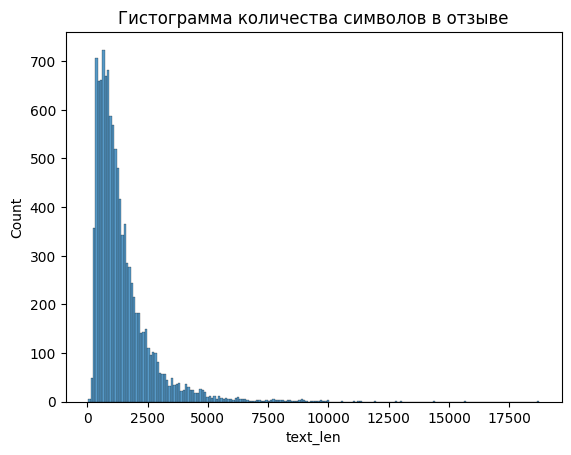

In [ ]:
sns.histplot(data=df_1, x="text_len")
plt.title('Гистограмма количества символов в отзыве');

### гистограмма по количеству слов

In [ ]:
import re
regex = re.compile("[а-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [ ]:
df_1['text_words'] = df_1['text'].str.lower().progress_apply(words_only)
df_1.head()

  0%|          | 0/11000 [00:00<?, ?it/s]

,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,city_copy_1,text_len,text_words
0,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,москва,1523,добрый день я не являюсь клиентом банка и пору...
1,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,новосибирск,1026,доброго дня являюсь держателем зарплатной карт...
2,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,москва,588,здравствуйте дублирую свое заявление от в до м...
3,False,Не тут-то было...,0,лицензия № 606,bankir76,Гагаринский,2015-06-05 11:37:31,"Я, как и многие вкладчики открыл на 1000 руб. ...",NaN,москва,555,я как и многие вкладчики открыл на руб со счас...
4,False,Вот так поворот!,0,лицензия № 2673,Altairseg,Тинькофф Банк,2015-06-05 11:59:01,Был крайне удивлён новостью от 27/28 мая - об ...,NaN,москва,726,был крайне удивл н новостью от мая об унификац...


In [ ]:
df_1['words_count'] = df_1['text_words'].progress_apply(lambda x: len(x.split()))
df_1.head(1)

  0%|          | 0/11000 [00:00<?, ?it/s]

,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,city_copy_1,text_len,text_words,words_count
0,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,москва,1523,добрый день я не являюсь клиентом банка и пору...,213


In [ ]:
df_1.words_count.describe()

count    11000.000000
mean       211.878000
std        183.100779
min          4.000000
25%         98.000000
50%        161.000000
75%        262.000000
max       2494.000000
Name: words_count, dtype: float64

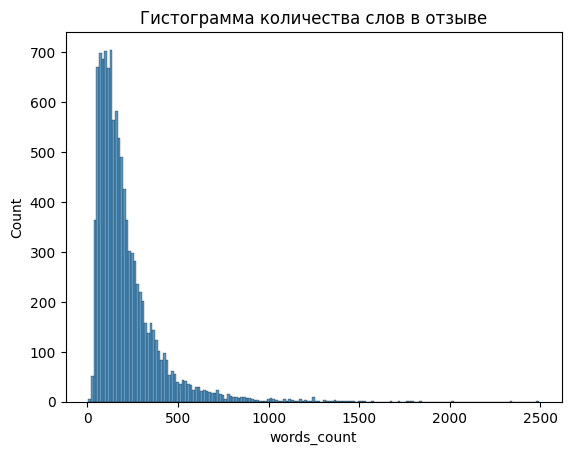

In [ ]:
sns.histplot(data=df_1, x='words_count')
plt.title('Гистограмма количества слов в отзыве');

## 3. Найдите 10 самых частых:

*   слов
*   слов без стоп-слов
*   лемм
*   существительных



### слова

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
from collections import Counter
corpus = [token for tweet in df_1.text for token in word_tokenize(tweet) if token not in punctuation]

In [ ]:
freq_dict = Counter(corpus) #составляем частотный словарь

freq_dict.most_common(10) # 10 самых частых слов

[('в', 76763),
 ('и', 64906),
 ('не', 54172),
 ('на', 42657),
 ('что', 38969),
 ('с', 29941),
 ('я', 28803),
 ('по', 23930),
 ('мне', 18650),
 ('банка', 16498)]

### слова без стоп-слов

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [ ]:
freq_dict.most_common(60) # просматриваю свои частотные слова, чтобы добавить в стопы

[('в', 76763),
 ('и', 64906),
 ('не', 54172),
 ('на', 42657),
 ('что', 38969),
 ('с', 29941),
 ('я', 28803),
 ('по', 23930),
 ('мне', 18650),
 ('банка', 16498),
 ('``', 13923),
 ("''", 13754),
 ('меня', 11675),
 ('банк', 11480),
 ('как', 10977),
 ('за', 10860),
 ('а', 10595),
 ('это', 10306),
 ('В', 10009),
 ('о', 9898),
 ('у', 9595),
 ('но', 9036),
 ('все', 8626),
 ('Я', 8516),
 ('к', 8015),
 ('от', 7874),
 ('деньги', 7691),
 ('так', 7669),
 ('было', 7279),
 ('же', 7272),
 ('для', 7265),
 ('карты', 6420),
 ('уже', 6383),
 ('карту', 5887),
 ('из', 5726),
 ('то', 5725),
 ('...', 5616),
 ('до', 5604),
 ('день', 5203),
 ('только', 5189),
 ('нет', 5058),
 ('через', 5017),
 ('раз', 4607),
 ('при', 4560),
 ('еще', 4543),
 ('был', 4498),
 ('И', 4447),
 ('бы', 4291),
 ('На', 4177),
 ('время', 4076),
 ('банке', 4016),
 ('года', 4005),
 ('отделение', 4004),
 ('заявление', 3946),
 ('со', 3920),
 ('этом', 3842),
 ('или', 3814),
 ('чтобы', 3785),
 ('была', 3774),
 ('«', 3772)]

На 60-ти самых частых словах видно, что исключение пунктуации плохо сработало.

In [ ]:
noise = stopwords.words('russian') + list(punctuation)+['«','``',"''",'...','ст','м','руб','очень','это','наш','тыс','млн','млрд','также','т','д']

In [ ]:
corpus_1 = [token for tweet in df_1.text for token in word_tokenize(tweet) if token not in noise]

In [ ]:
freq_dict_1 = Counter(corpus_1) #составляем частотный словарь

freq_dict_1.most_common(60)

[('банка', 16498),
 ('банк', 11480),
 ('В', 10009),
 ('Я', 8516),
 ('деньги', 7691),
 ('карты', 6420),
 ('карту', 5887),
 ('день', 5203),
 ('И', 4447),
 ('На', 4177),
 ('время', 4076),
 ('банке', 4016),
 ('года', 4005),
 ('отделение', 4004),
 ('заявление', 3946),
 ('2', 3756),
 ('»', 3738),
 ('кредит', 3620),
 ('счет', 3593),
 ('Но', 3489),
 ('дней', 3487),
 ('рублей', 3337),
 ('А', 3072),
 ('Банк', 3031),
 ('сумму', 3017),
 ('номер', 2963),
 ('средств', 2895),
 ('вклад', 2860),
 ('ответ', 2858),
 ('вопрос', 2801),
 ('1', 2708),
 ('3', 2693),
 ('счета', 2592),
 ('карта', 2574),
 ('карте', 2465),
 ('денег', 2439),
 ('просто', 2429),
 ('отделении', 2426),
 ('могу', 2365),
 ('банком', 2332),
 ('вклада', 2326),
 ('Банка', 2308),
 ('кредита', 2285),
 ('сотрудники', 2283),
 ('который', 2249),
 ('моей', 2248),
 ('средства', 2222),
 ('которые', 2138),
 ('мои', 2129),
 ('клиентов', 2123),
 ('т.к', 2103),
 ('сотрудников', 2031),
 ('сказали', 2011),
 ('офис', 2008),
 ('нужно', 2007),
 ('5', 1978)

Мне не нравится результат. Поэтому для дальнейшей работы буду использовать столбец 'text_words',предобработанный через регулярку.

In [ ]:
def remove_stopwords(text, mystopwords = noise):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [ ]:
df_1['text_without_stop_words'] = df_1['text_words'].progress_apply(remove_stopwords)

  0%|          | 0/11000 [00:00<?, ?it/s]

In [ ]:
cnt_stop = Counter()
n_types_stop = []
n_tokens_stop = []
tokens_stop = []
for index, row in tqdm(df_1.iterrows(), total = len(df_1)):
    tokens_stop = row['text_without_stop_words'].split()
    cnt_stop.update(tokens_stop)
    n_types_stop.append(len(cnt_stop))
    n_tokens_stop.append(sum(list(cnt_stop.values())))
for i in cnt_stop.most_common(10):
    print(i) # 10 самых частых слов без стоп-слов

100%|██████████| 11000/11000 [00:57<00:00, 189.85it/s]

('банка', 19691)
('банк', 16115)
('деньги', 8281)
('карты', 6627)
('карту', 6152)
('день', 5322)
('банке', 4962)
('заявление', 4318)
('время', 4215)
('отделение', 4164)


In [ ]:
cnt_stop.most_common(100) # смотрю "глазами", чтобы отредактировать стоп-слова

[('банка', 19691),
 ('банк', 16115),
 ('деньги', 8281),
 ('карты', 6627),
 ('карту', 6152),
 ('день', 5322),
 ('банке', 4962),
 ('заявление', 4318),
 ('время', 4215),
 ('отделение', 4164),
 ('г', 4157),
 ('кредит', 4124),
 ('года', 4071),
 ('счет', 3751),
 ('смс', 3537),
 ('дней', 3534),
 ('почему', 3494),
 ('рублей', 3400),
 ('ответ', 3280),
 ('номер', 3255),
 ('вопрос', 3237),
 ('сумму', 3072),
 ('вклад', 3045),
 ('банком', 2995),
 ('средств', 2919),
 ('карта', 2884),
 ('сегодня', 2866),
 ('сотрудники', 2797),
 ('просто', 2702),
 ('счета', 2680),
 ('денег', 2517),
 ('карте', 2506),
 ('сотрудник', 2495),
 ('интернет', 2452),
 ('отделении', 2447),
 ('могу', 2445),
 ('прошу', 2413),
 ('вклада', 2411),
 ('кредита', 2334),
 ('мои', 2310),
 ('моей', 2290),
 ('е', 2290),
 ('который', 2275),
 ('средства', 2272),
 ('сумма', 2202),
 ('сказали', 2192),
 ('клиентов', 2173),
 ('которые', 2155),
 ('офис', 2150),
 ('нужно', 2084),
 ('договора', 2076),
 ('банку', 2069),
 ('сотрудников', 2058),
 ('кл

In [ ]:
noise = noise+['г','с','е','р','вс','хотя','моей','нужно','мои','сразу','вообще','буду','либо','пока','мной']

In [ ]:
def remove_stopwords(text, mystopwords = noise):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [ ]:
df_1['кор_text_without_stop_words'] = df_1['text_words'].progress_apply(remove_stopwords)

  0%|          | 0/11000 [00:00<?, ?it/s]

In [ ]:
cnt_stop = Counter()
n_types_stop = []
n_tokens_stop = []
tokens_stop = []
for index, row in tqdm(df_1.iterrows(), total = len(df_1)):
    tokens_stop = row['кор_text_without_stop_words'].split()
    cnt_stop.update(tokens_stop)
    n_types_stop.append(len(cnt_stop))
    n_tokens_stop.append(sum(list(cnt_stop.values())))
for i in cnt_stop.most_common(10):
    print(i) # 10 самых частых слов без стоп-слов (обновлено)

100%|██████████| 11000/11000 [00:58<00:00, 189.43it/s]


('банка', 19691)
('банк', 16115)
('деньги', 8281)
('карты', 6627)
('карту', 6152)
('день', 5322)
('банке', 4962)
('заявление', 4318)
('время', 4215)
('отделение', 4164)


In [ ]:
cnt_stop.most_common(100) # проверяю результат "глазами"

[('банка', 19691),
 ('банк', 16115),
 ('деньги', 8281),
 ('карты', 6627),
 ('карту', 6152),
 ('день', 5322),
 ('банке', 4962),
 ('заявление', 4318),
 ('время', 4215),
 ('отделение', 4164),
 ('кредит', 4124),
 ('года', 4071),
 ('счет', 3751),
 ('смс', 3537),
 ('дней', 3534),
 ('почему', 3494),
 ('рублей', 3400),
 ('ответ', 3280),
 ('номер', 3255),
 ('вопрос', 3237),
 ('сумму', 3072),
 ('вклад', 3045),
 ('банком', 2995),
 ('средств', 2919),
 ('карта', 2884),
 ('сегодня', 2866),
 ('сотрудники', 2797),
 ('просто', 2702),
 ('счета', 2680),
 ('денег', 2517),
 ('карте', 2506),
 ('сотрудник', 2495),
 ('интернет', 2452),
 ('отделении', 2447),
 ('могу', 2445),
 ('прошу', 2413),
 ('вклада', 2411),
 ('кредита', 2334),
 ('который', 2275),
 ('средства', 2272),
 ('сумма', 2202),
 ('сказали', 2192),
 ('клиентов', 2173),
 ('которые', 2155),
 ('офис', 2150),
 ('договора', 2076),
 ('банку', 2069),
 ('сотрудников', 2058),
 ('клиентом', 2020),
 ('несколько', 1985),
 ('телефону', 1985),
 ('минут', 1954),
 (

Получился, конечно, не идеальный результат. Но, в целом, можно оставить)

In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   rating_not_checked           11000 non-null  bool   
 1   title                        10970 non-null  object 
 2   num_comments                 11000 non-null  int64  
 3   bank_license                 11000 non-null  object 
 4   author                       11000 non-null  object 
 5   bank_name                    11000 non-null  object 
 6   datetime                     11000 non-null  object 
 7   text                         11000 non-null  object 
 8   rating_grade                 5080 non-null   float64
 9   city_copy_1                  11000 non-null  object 
 10  text_len                     11000 non-null  int64  
 11  text_words                   11000 non-null  object 
 12  text_without_stop_words      11000 non-null  object 
 13  кор_text_without

In [ ]:
df_2=df_1.drop(['text_len','text_words','text_without_stop_words'], axis=1) # удалили не нужные далее столбцы

In [ ]:
df_2.head(1)

,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,city_copy_1,кор_text_without_stop_words
0,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,москва,добрый день являюсь клиентом банка поручителем...


In [ ]:
df_1.to_csv (r'1_new_export_dataframe.csv', index = None, header=True)

In [ ]:
df_2.to_csv (r'2_new_export_dataframe.csv', index = None, header=True)

### леммы

In [ ]:
df_2 = pd.read_csv('2_new_export_dataframe.csv')

In [ ]:
!pip install pymorphy2

In [ ]:
import pymorphy2
m = pymorphy2.MorphAnalyzer()
# pymorphy2 работает с отдельными словами. Если дать ему на вход предложение - он его просто не лемматизирует, т.к. не понимает

In [ ]:
def lemmatize(text, morph=m):
    try:
        return ' '.join([morph.parse(word)[0].normal_form for word in text.split()])
    except:
        return " "


In [ ]:
df_2['lemma'] = df_2['кор_text_without_stop_words'].progress_apply(lemmatize)

  0%|          | 0/11000 [00:00<?, ?it/s]

In [ ]:
cnt_lemmas = Counter()
n_types_lemmas = []
n_tokens_lemmas = []
tokens_lemmas = []
for index, row in tqdm(df_2.iterrows(), total = len(df_2)):
    tokens_lemmas = row['lemma'].split()
    cnt_lemmas.update(tokens_lemmas)
    n_types_lemmas.append(len(cnt_lemmas))
    n_tokens_lemmas.append(sum(list(cnt_lemmas.values())))
for i in cnt_lemmas.most_common(10): # 10 самых частых лемм
    print(i)

100%|██████████| 11000/11000 [00:22<00:00, 498.07it/s]

('банк', 48331)
('карта', 20782)
('день', 11446)
('деньга', 11232)
('который', 10503)
('сотрудник', 10356)
('клиент', 9821)
('отделение', 8956)
('кредит', 8784)
('счёт', 8506)


вроде бы нормально отработано, если не считать 'деньгА')))))

In [ ]:
cnt_lemmas.most_common(60) # визуальная проверка)

[('банк', 48331),
 ('карта', 20782),
 ('день', 11446),
 ('деньга', 11232),
 ('который', 10503),
 ('сотрудник', 10356),
 ('клиент', 9821),
 ('отделение', 8956),
 ('кредит', 8784),
 ('счёт', 8506),
 ('вклад', 7812),
 ('сумма', 7634),
 ('год', 7489),
 ('свой', 7189),
 ('мой', 7085),
 ('заявление', 6619),
 ('сказать', 6475),
 ('вопрос', 6393),
 ('время', 6004),
 ('договор', 5764),
 ('мочь', 5658),
 ('средство', 5504),
 ('получить', 5478),
 ('кредитный', 5380),
 ('ответ', 5352),
 ('такой', 5342),
 ('номер', 5259),
 ('телефон', 5246),
 ('ваш', 5165),
 ('дать', 4888),
 ('платёж', 4864),
 ('офис', 4592),
 ('звонок', 4584),
 ('звонить', 4300),
 ('рубль', 4261),
 ('проблема', 4239),
 ('ситуация', 3940),
 ('месяц', 3886),
 ('операция', 3877),
 ('какой', 3848),
 ('сбербанк', 3843),
 ('информация', 3838),
 ('работа', 3769),
 ('написать', 3764),
 ('позвонить', 3690),
 ('данный', 3596),
 ('человек', 3595),
 ('документ', 3543),
 ('смс', 3537),
 ('работать', 3524),
 ('услуга', 3513),
 ('должный', 3502)

In [ ]:
df_2.to_csv (r'3_new_export_dataframe.csv', index = None, header=True)

### существительные

In [ ]:
df_2 = pd.read_csv('3_new_export_dataframe.csv')

In [ ]:
# pymorphy2 Часть речи можно получить через атрибут POS

In [ ]:
p = m.parse('жена')[0]
p.tag.POS

'NOUN'

In [ ]:
cnt_noun = Counter()
n_types_noun = []
n_tokens_noun = []
tokens_noun = []
for index, row in tqdm(df_2.iterrows(), total = len(df_2)):
    tokens_noun = [m.parse(word)[0].normal_form for word in row['lemma'].split() if m.parse(word)[0].tag.POS == 'NOUN'] # NOUN -существительное (список граммем)
    cnt_noun.update(tokens_noun)
    n_types_noun.append(len(cnt_noun))
    n_tokens_noun.append(sum(list(cnt_noun.values())))
for i in cnt_noun.most_common(10): # 10 самых частых существительных
    print(i)

100%|██████████| 11000/11000 [06:02<00:00, 30.34it/s]

('банк', 48331)
('карта', 20782)
('день', 11446)
('деньга', 11232)
('сотрудник', 10356)
('клиент', 9821)
('отделение', 8956)
('кредит', 8784)
('счёт', 8506)
('вклад', 7812)


Надо бы исправить 'деньгУ'...

In [ ]:
m.parse('деньги')[0].normal_form

'деньга'

In [ ]:
m.parse('денег')[0].normal_form

'деньга'

In [ ]:
m.parse('деньга')[0].inflect({'plur', 'nomn'}).word

'деньги'

Вычитала, что в pymorphy2 имена существительные употребляемые только во множественном числе должны быть с пометкой Pltm ("Pluralia tantum")

In [ ]:
m.parse('деньги')

[Parse(word='деньги', tag=OpencorporaTag('NOUN,inan,femn plur,accs'), normal_form='деньга', score=0.632398, methods_stack=((DictionaryAnalyzer(), 'деньги', 1328, 10),)),
 Parse(word='деньги', tag=OpencorporaTag('NOUN,inan,femn plur,nomn'), normal_form='деньга', score=0.36137, methods_stack=((DictionaryAnalyzer(), 'деньги', 1328, 7),)),
 Parse(word='деньги', tag=OpencorporaTag('NOUN,inan,femn sing,gent,Infr'), normal_form='деньга', score=0.00623, methods_stack=((DictionaryAnalyzer(), 'деньги', 1328, 1),))]

Пометки нет. Надо в словарь изменение вносить?

## 4. Постройте кривые Ципфа и Хипса

Кривые буду строить на лемматизированных данных с учётом всех частей речи

### кривая Ципфа

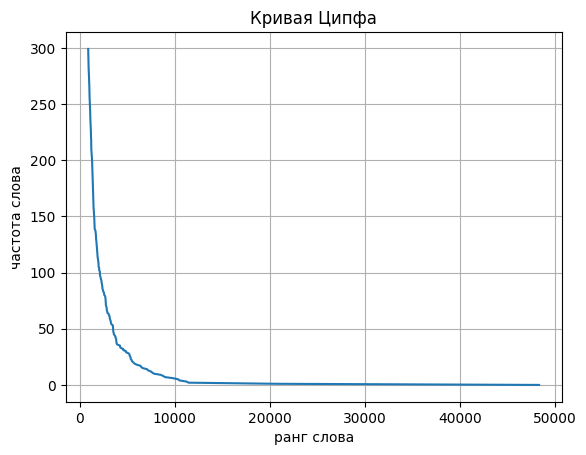

In [ ]:
freqs = list(cnt_lemmas.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.grid()
plt.title('Кривая Ципфа')
plt.ylabel('частота слова')
plt.xlabel('ранг слова');

### кривая Хипса

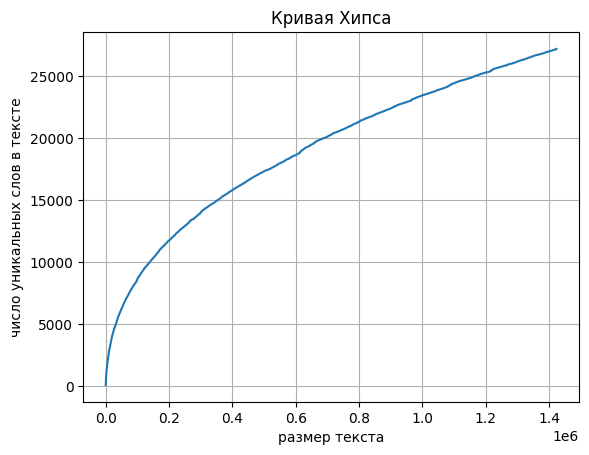

In [ ]:
fig, ax = plt.subplots()
ax.plot(n_tokens_lemmas, n_types_lemmas)
plt.grid()
plt.title('Кривая Хипса')
plt.ylabel('число уникальных слов в тексте')
plt.xlabel('размер текста');

## 5. Ответьте на следующие вопросы:
*   какое слово встречается чаще, "сотрудник" или "клиент"?
*   сколько раз встречается слова "мошенничество" и "доверие"?



### "сотрудник" или "клиент"?

In [ ]:
print('слово "сотрудник" встречается', cnt_lemmas['сотрудник'], 'раз')
print('слово "клиент" встречается', cnt_lemmas['клиент'], 'раз')

слово "сотрудник" встречается 10356 раз
слово "клиент" встречается 9821 раз


In [ ]:
if cnt_lemmas['сотрудник'] > cnt_lemmas['клиент']:
      print('слово "сотрудник" встречается в', round(cnt_lemmas['сотрудник']/cnt_lemmas['клиент'],3), 'раз чаще, чем слово "клиент"')
else:
      print('слово "клиент" встречается в', round(cnt_lemmas['клиент']/cnt_lemmas['сотрудник'],3), 'раз чаще, чем слово "сотрудник"')

слово "сотрудник" встречается в 1.054 раз чаще, чем слово "клиент"


### "мошенничество" и "доверие"?

In [ ]:
print('слово "мошенничество" встречается', cnt_lemmas['мошенничество'], 'раз')
print('слово "доверие" встречается', cnt_lemmas['доверие'], 'раз')

слово "мошенничество" встречается 256 раз
слово "доверие" встречается 177 раз


##  6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру tf−idf, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [ ]:
df_2['rating_grade'].unique()

array([nan,  2.,  1.,  5.,  4.,  3.])

In [ ]:
df_2['rating_grade'].fillna(0, inplace=True) #заменили nan на 0

In [ ]:
df_2.rating_grade.value_counts() # распределение оценок

0.0    5920
1.0    2999
2.0     812
5.0     660
3.0     440
4.0     169
Name: rating_grade, dtype: int64

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tokens_by_rating = []
for rating in range(6):
    print(rating)
    tokens = []
    sample = df_2[df_2['rating_grade']==rating]['lemma']

    for i in range(len(sample)):
        tokens += sample.iloc[i].split()
    tokens_by_rating.append(tokens)

0
1
2
3
4
5


### ключевые слова и биграмы для положительных отзывов

In [ ]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_rating])
feature_names = tfidf.get_feature_names_out()
tfidf_ranking5_uni = []
dense = tfidf_matrix.todense()

text = dense[5].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking5_uni.append(phrase)

In [ ]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_rating])
feature_names = tfidf.get_feature_names_out()
tfidf_ranking5_bi = []
dense = tfidf_matrix.todense()

text = dense[5].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking5_bi.append(phrase)

In [ ]:
rankings5 = pd.DataFrame({'ключевые слова положительных отзывов': tfidf_ranking5_uni, 'биграмы положительных отзывов': tfidf_ranking5_bi})
rankings5.head(20)

,ключевые слова положительных отзывов,биграмы положительных отзывов
0,банк,интернет банк
1,карта,кредитный карта
2,клиент,сотрудник банк
3,вклад,другой банк
4,сотрудник,клиент банк
5,день,дебетовый карта
6,отделение,добрый день
7,который,отделение банк
8,вопрос,банк который
9,год,открыть вклад


### ключевые слова и биграмы для отрицательных отзывов

In [ ]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_rating])
feature_names = tfidf.get_feature_names_out()
tfidf_ranking1_uni = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking1_uni.append(phrase)


In [ ]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_rating])
feature_names = tfidf.get_feature_names_out()
tfidf_ranking1_bi = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking1_bi.append(phrase)

In [ ]:
rankings1 = pd.DataFrame({'ключевые слова отрицательных отзывов': tfidf_ranking1_uni, 'биграмы отрицательных отзывов': tfidf_ranking1_bi})
rankings1.head(20)

,ключевые слова отрицательных отзывов,биграмы отрицательных отзывов
0,банк,сотрудник банк
1,карта,денежный средство
2,деньга,отделение банк
3,день,кредитный карта
4,сотрудник,написать заявление
5,отделение,горячий линия
6,который,колл центр
7,клиент,интернет банк
8,счёт,добрый день
9,кредит,рабочий день


# Часть 2. Тематическое моделирование

## 1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

In [ ]:
import gensim.corpora as corpora
from gensim.models import *

In [ ]:
from sklearn.metrics import *
from sklearn.pipeline import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import Normalizer, LabelEncoder

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
texts = [df_2['lemma'].iloc[i].split() for i in range(len(df_2))]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print("Тематическая модель с 10 темами")

%time
lda_10 = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, chunksize=50, update_every=1, passes=2, random_state=42, alpha='auto', eta='auto')
# num_topics ( int , необязательный ) — количество запрошенных скрытых тем, которые необходимо извлечь из учебного корпуса.
# chunksize ( int , необязательный ) — количество документов, которые будут использоваться в каждом обучающем фрагменте.
# update_every ( int , необязательный ) — количество документов, которые необходимо перебирать для каждого обновления. Установите 0 для пакетного обучения, > 1 для интерактивного итеративного обучения.
# pass ( int , необязательный ) — количество проходов по корпусу во время обучения.
# alpha – Априорное убеждение в распространении темы документа. 'auto': изучает асимметричный априор из корпуса (недоступно, если Distributed==True ).
# eta - Априорное убеждение в распределении слов по теме.'auto': изучает асимметричный априор из корпуса.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Тематическая модель с 10 темами
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs


In [ ]:
lda_10.show_topics(num_topics=3, num_words=20, formatted=False)
# num_topics ( int , необязательный ) — количество возвращаемых тем. В отличие от LSA, в LDA нет естественного порядка между темами. Таким образом, возвращаемое подмножество тем для всех тем является произвольным и может измениться между двумя прогонами обучения LDA.
# num_words ( int , необязательный ) — количество слов, которые будут представлены для каждой темы.
# formatted ( bool , необязательный ) — должны ли представления темы быть отформатированы как строки. Если False, они возвращаются как 2 кортежа (слово, вероятность).

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(7,
  [('снять', 0.05840827),
   ('кошелёк', 0.034749188),
   ('доступ', 0.024603607),
   ('мобильный', 0.021761017),
   ('возникать', 0.019857455),
   ('мошенник', 0.014493859),
   ('регистрация', 0.014425025),
   ('статус', 0.0139903715),
   ('кодовый', 0.013636678),
   ('интересный', 0.01329025),
   ('получатель', 0.013215681),
   ('безопасность', 0.012384046),
   ('успешно', 0.011242444),
   ('владелец', 0.0107587045),
   ('середина', 0.01014018),
   ('телебанк', 0.00973647),
   ('система', 0.009120459),
   ('впервые', 0.008969583),
   ('граница', 0.008808394),
   ('постоянный', 0.008645346)]),
 (0,
  [('деньга', 0.029645747),
   ('день', 0.027838657),
   ('счёт', 0.027525183),
   ('банк', 0.025371982),
   ('заявление', 0.02062054),
   ('средство', 0.016811566),
   ('сбербанк', 0.015382165),
   ('ответ', 0.014870037),
   ('перевод', 0.013433118),
   ('карта', 0.01272535),
   ('мой', 0.011304831),
   ('написать', 0.010765735),
   ('отделение', 0.010746887),
   ('платёж', 0.01068148

По темам __модели lda_10__ мысли такие:

тема №0. затрудняюсь...

тема №3. новогодние вклады в отделении банка?

тема №7. услуги онлайн-банка?

In [ ]:
print("Тематическая модель с 20 темами")

%time
lda_20 = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2, random_state=42, alpha='auto', eta='auto')

Тематическая модель с 20 темами
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11.2 µs


In [ ]:
lda_20.show_topics(num_topics=3, num_words=20, formatted=False)

[(5,
  [('страховка', 0.1390002),
   ('страхование', 0.103005104),
   ('запись', 0.09286817),
   ('страховой', 0.08487857),
   ('программа', 0.06290451),
   ('кредит', 0.034983322),
   ('организовать', 0.033896185),
   ('менеджер', 0.030776339),
   ('транспортный', 0.03003735),
   ('участие', 0.024629548),
   ('обязательный', 0.02393729),
   ('вернуть', 0.02221561),
   ('одобрить', 0.016205126),
   ('полис', 0.012499566),
   ('оформление', 0.011738019),
   ('сходненский', 0.009767123),
   ('оформить', 0.008787359),
   ('услуга', 0.008054018),
   ('оформлять', 0.005478502),
   ('согласиться', 0.005315959)]),
 (2,
  [('банк', 0.12357158),
   ('сотрудник', 0.046877895),
   ('который', 0.027709771),
   ('год', 0.018466482),
   ('мой', 0.018086175),
   ('клиент', 0.016955286),
   ('документ', 0.015944613),
   ('свой', 0.014942972),
   ('дать', 0.014551382),
   ('получить', 0.013166121),
   ('вопрос', 0.01284492),
   ('иметь', 0.012826461),
   ('какой', 0.012356128),
   ('принять', 0.0112157

По __модели lda_20__ понятная тема:

тема №18. долгое обслуживание в отделениях банка

In [ ]:
print("Тематическая модель с 30 темами")

%time
lda_30 = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=30, chunksize=50, update_every=1, passes=2, random_state=42, alpha='auto', eta='auto')

Тематическая модель с 30 темами
CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.4 µs


In [ ]:
lda_30.show_topics(num_topics=3, num_words=30, formatted=False)

[(27,
  [('исполнить', 0.17766395),
   ('поручение', 0.17678915),
   ('преступление', 0.006053201),
   ('перетащить', 2.3496976e-05),
   ('ренессанскредит', 2.3496976e-05),
   ('нижесказанный', 2.3496976e-05),
   ('монополист', 2.3496976e-05),
   ('многозначительный', 2.3496976e-05),
   ('кукуевск', 2.3496976e-05),
   ('колбасить', 2.3496976e-05),
   ('кашлять', 2.3496976e-05),
   ('вязанка', 2.3496976e-05),
   ('выхватывать', 2.3496976e-05),
   ('брючки', 2.3496976e-05),
   ('паспортистка', 2.3496976e-05),
   ('агрегат', 2.3496976e-05),
   ('сюрреализм', 2.3496976e-05),
   ('своеобразно', 2.3496976e-05),
   ('ругательный', 2.3496976e-05),
   ('путаный', 2.3496976e-05),
   ('посм', 2.3496976e-05),
   ('закипать', 2.3496976e-05),
   ('ахинея', 2.3496976e-05),
   ('привнесение', 2.3496976e-05),
   ('парадокс', 2.3496976e-05),
   ('дыбом', 2.3496976e-05),
   ('выдчау', 2.3496976e-05),
   ('порасти', 2.3496976e-05),
   ('извилистый', 2.3496976e-05),
   ('шейнкмана', 2.3496976e-05)]),
 (29,

По __модели lda_30__ интересная тема №27 - какой-то скандал в реннесансе из кукуевска?)))

In [ ]:
print("Тематическая модель со 100 темами")

%time
lda_100 = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=100, chunksize=50, update_every=1, passes=2, random_state=42, alpha='auto', eta='auto')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Тематическая модель со 100 темами
CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10.7 µs


In [ ]:
lda_100.show_topics(num_topics=3, num_words=30, formatted=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(30,
  [('паспортистка', 3.6739042e-05),
   ('извилистый', 3.6739042e-05),
   ('перетащить', 3.6739042e-05),
   ('отпбанк', 3.6739042e-05),
   ('нижесказанный', 3.6739042e-05),
   ('монополист', 3.6739042e-05),
   ('многозначительный', 3.6739042e-05),
   ('кукуевск', 3.6739042e-05),
   ('колбасить', 3.6739042e-05),
   ('кашлять', 3.6739042e-05),
   ('вязанка', 3.6739042e-05),
   ('выхватывать', 3.6739042e-05),
   ('брючки', 3.6739042e-05),
   ('агрегат', 3.6739042e-05),
   ('сюрреализм', 3.6739042e-05),
   ('своеобразно', 3.6739042e-05),
   ('ругательный', 3.6739042e-05),
   ('путаный', 3.6739042e-05),
   ('посм', 3.6739042e-05),
   ('закипать', 3.6739042e-05),
   ('ахинея', 3.6739042e-05),
   ('привнесение', 3.6739042e-05),
   ('парадокс', 3.6739042e-05),
   ('дыбом', 3.6739042e-05),
   ('выдчау', 3.6739042e-05),
   ('татфонбанк', 3.6739042e-05),
   ('ренессанскредит', 3.6739042e-05),
   ('петепетелькин', 3.6739042e-05),
   ('шейнкмана', 3.6739042e-05),
   ('алфёров', 3.6739042e-05)]

## 2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

In [ ]:
lda_10.get_term_topics('сбербанк') # Получить наиболее релевантные темы для данного слова.
# word_id ( int ) — слово, для которого будет вычислено распределение тем.
# Minimum_probability ( float , необязательный ) — Темы с назначенной вероятностью ниже этого порога будут отброшены.
# Возвращает: Релевантные темы представлены в виде пар их идентификаторов и назначенных им вероятностей, отсортированных по релевантности данному слову.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.01538892)]

In [ ]:
lda_100.get_term_topics('сбербанк')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(10, 0.52659374)]

In [ ]:
lda_100.print_topic(10, topn=30) # Получить одну тему в виде форматированной строки.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'0.526*"сбербанк" + 0.176*"онлайн" + 0.108*"россия" + 0.039*"выслать" + 0.037*"муж" + 0.022*"сменить" + 0.020*"ощущение" + 0.012*"скан" + 0.012*"рано" + 0.007*"высылать" + 0.001*"фамилия" + 0.000*"адрес" + 0.000*"результат" + 0.000*"паспорт" + 0.000*"почему" + 0.000*"который" + 0.000*"мочь" + 0.000*"выдать" + 0.000*"ситуация" + 0.000*"сотрудник" + 0.000*"разобраться" + 0.000*"другой" + 0.000*"главный" + 0.000*"просить" + 0.000*"смочь" + 0.000*"информация" + 0.000*"отделение" + 0.000*"сообщить" + 0.000*"должный" + 0.000*"день"'

тема №10 из lda_100, в которой упомянут сбербанк, скорее всего о перебоях в онлайн-банке

In [ ]:
lda_100.get_term_topics('втб')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(5, 0.2356805)]

In [ ]:
lda_100.print_topic(5, topn=30)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'0.236*"втб" + 0.228*"руководство" + 0.157*"запись" + 0.112*"количество" + 0.057*"организовать" + 0.051*"транспортный" + 0.042*"возмещение" + 0.042*"участие" + 0.000*"клиент" + 0.000*"работа" + 0.000*"сотрудник" + 0.000*"банк" + 0.000*"выполнять" + 0.000*"который" + 0.000*"вопрос" + 0.000*"являться" + 0.000*"соответственно" + 0.000*"получить" + 0.000*"информация" + 0.000*"время" + 0.000*"поэтому" + 0.000*"вчера" + 0.000*"порасти" + 0.000*"брючки" + 0.000*"агрегат" + 0.000*"паспортистка" + 0.000*"перетащить" + 0.000*"петепетелькин" + 0.000*"потряхивать" + 0.000*"вязанка"'

тема №5 из lda_100, в которой упомянут ВТБ, затрудняюсь... как записаться к руководству ВТБ?

In [ ]:
lda_100.get_term_topics('банк')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(3, 0.014300499),
 (23, 0.01224816),
 (60, 0.113255255),
 (61, 0.042187802),
 (66, 0.16191305),
 (81, 0.08645984),
 (83, 0.021782773)]

# Часть 3. Классификация текстов

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

## 1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   rating_not_checked           11000 non-null  bool   
 1   title                        10970 non-null  object 
 2   num_comments                 11000 non-null  int64  
 3   bank_license                 11000 non-null  object 
 4   author                       11000 non-null  object 
 5   bank_name                    11000 non-null  object 
 6   datetime                     11000 non-null  object 
 7   text                         11000 non-null  object 
 8   rating_grade                 5080 non-null   float64
 9   city_copy_1                  11000 non-null  object 
 10  кор_text_without_stop_words  11000 non-null  object 
 11  lemma                        11000 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 956.2+ KB


In [ ]:
df_N1_N2=df_2.loc[df_2.rating_grade.isin([1,5])]

In [ ]:
df_N1_N2.rating_grade.value_counts(dropna=False) # смотрим сбалансированность данных

1.0    2999
5.0     660
Name: rating_grade, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
le.fit(df_N1_N2.rating_grade)

LabelEncoder()

In [ ]:
le.transform( ['1', '5']) # пример расшифровки

array([0, 1])

In [ ]:
y = pd.Series (le.transform(df_N1_N2.rating_grade))
y.head(10)

0    0
1    0
2    0
3    0
4    1
5    0
6    0
7    0
8    0
9    0
dtype: int64

In [ ]:
X=df_N1_N2.lemma

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(df_N1_N2.shape[0])
print(X_train.shape)
print(X_test.shape)

3659
(2927,)
(732,)


## 2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных -грам.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

In [ ]:
vec_1 = CountVectorizer(ngram_range=(1, 1)) # униграмы
bow_1 = vec_1.fit_transform(X_train) # bow -- bag of words (мешок слов)

In [ ]:
clf_1 = LogisticRegression(random_state=42, solver='liblinear')
clf_1.fit(bow_1, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [ ]:
pred_1 = clf_1.predict(vec_1.transform(X_test))
print(classification_report(pred_1, y_test, target_names=['негатив (оценка 1)', 'позитив (оценка 5)']))

                    precision    recall  f1-score   support

негатив (оценка 1)       0.99      0.98      0.98       606
позитив (оценка 5)       0.90      0.94      0.92       126

          accuracy                           0.97       732
         macro avg       0.94      0.96      0.95       732
      weighted avg       0.97      0.97      0.97       732



In [ ]:
vec_2 = CountVectorizer(ngram_range=(2, 2)) # биграмы
bow_2 = vec_2.fit_transform(X_train)
clf_2 = LogisticRegression(random_state=42)
clf_2.fit(bow_2, y_train)
pred_2 = clf_2.predict(vec_2.transform(X_test))
print(classification_report(pred_2, y_test, target_names=['негатив (оценка 1)', 'позитив (оценка 5)']))

                    precision    recall  f1-score   support

негатив (оценка 1)       1.00      0.87      0.93       686
позитив (оценка 5)       0.34      0.98      0.51        46

          accuracy                           0.88       732
         macro avg       0.67      0.93      0.72       732
      weighted avg       0.96      0.88      0.90       732



In [ ]:
vec_3 = CountVectorizer(ngram_range=(3, 3)) # триграмы
bow_3 = vec_3.fit_transform(X_train)
clf_3 = LogisticRegression(random_state=42)
clf_3.fit(bow_3, y_train)
pred_3 = clf_3.predict(vec_3.transform(X_test))
print(classification_report(pred_3, y_test, target_names=['негатив (оценка 1)', 'позитив (оценка 5)']))

                    precision    recall  f1-score   support

негатив (оценка 1)       1.00      0.82      0.90       732
позитив (оценка 5)       0.00      0.00      0.00         0

          accuracy                           0.82       732
         macro avg       0.50      0.41      0.45       732
      weighted avg       1.00      0.82      0.90       732



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
report_1 = classification_report(y_test, pred_1, output_dict=True)
df_r_1 = pd.DataFrame(report_1)
report_2 = classification_report(y_test, pred_2, output_dict=True)
df_r_2 = pd.DataFrame(report_2)
report_3 = classification_report(y_test, pred_3, output_dict=True)
df_r_3 = pd.DataFrame(report_3)

In [ ]:
test_1=pd.Series(df_r_1[2:3]['macro avg'], name='униграмы')
test_1=pd.DataFrame(test_1)
test_2=pd.Series(df_r_2[2:3]['macro avg'], name='биграмы')
test_2=pd.DataFrame(test_2)
test_3=pd.Series(df_r_3[2:3]['macro avg'], name='триграмы')
test_3=pd.DataFrame(test_3)
test_concat = pd.concat([test_1, test_2,test_3], axis=1)

In [ ]:
test_concat

,униграмы,биграмы,триграмы
f1-score,0.952948,0.718594,0.45045


Лучший результат показали униграмы. Это может быть связано с тем, что я использовала сильно уменьшенный объем данных.

## 3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:


*   1-ый вариант: tf−idf преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
*   2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.


В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.



In [ ]:
from sklearn.pipeline import Pipeline # pipeline позволяет объединить в один блок трансформер и модель, что упрощает написание кода и улучшает его читаемость
from sklearn.feature_extraction.text import TfidfVectorizer # TfidfVectorizer преобразует тексты в числовые вектора, отражающие важность использования каждого слова из некоторого набора слов (количество слов набора определяет размерность вектора) в каждом тексте
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.model_selection import GridSearchCV # модуль поиска по сетке параметров
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier

### c класификатором из п.3.2

Чтобы создать конвейер, нам нужен список пар (ключ, значение), где ключ — это строка, содержащая то, что вы хотите назвать шагом, а значение — это объект оценки. Каждый шаг этого конвейера должен быть преобразователем, за исключением последнего шага, который может быть оценочного типа.

In [ ]:
ppl_clf_1 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('tm', TruncatedSVD()),
    ('clf', LogisticRegression(random_state=42))])
ppl_clf_2 = Pipeline([
    ('vect', CountVectorizer()),
    ('lda', LatentDirichletAllocation()),
    ('clf', LogisticRegression(random_state=42))])

In [ ]:
ppl_clf_1.fit(X_train, y_train)
ppl_clf_2.fit(X_train, y_train)

In [ ]:
pred_ppl_clf_1 = ppl_clf_1.predict(X_test)
print(classification_report(pred_ppl_clf_1, y_test, target_names=['негатив (оценка 1)', 'позитив (оценка 5)']))

                    precision    recall  f1-score   support

негатив (оценка 1)       1.00      0.82      0.90       732
позитив (оценка 5)       0.00      0.00      0.00         0

          accuracy                           0.82       732
         macro avg       0.50      0.41      0.45       732
      weighted avg       1.00      0.82      0.90       732



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pred_ppl_clf_2 = ppl_clf_2.predict(X_test)
print(classification_report(pred_ppl_clf_2, y_test, target_names=['негатив (оценка 1)', 'позитив (оценка 5)']))

                    precision    recall  f1-score   support

негатив (оценка 1)       1.00      0.85      0.92       704
позитив (оценка 5)       0.20      0.93      0.32        28

          accuracy                           0.85       732
         macro avg       0.60      0.89      0.62       732
      weighted avg       0.97      0.85      0.89       732



В связи с тем, что датасет не сбалансирован, метрику «accuracy» (доля верных ответов) использовать нельзя, так как это приведет к завышенной оценке качества работы классификатора.

Для сравнения двух классификаторов использую «macro-avg» (точность, полнота и f-мера).

Лучший результат показал классификатор с использованием LDA (0,62 против 0,45).

Теперь сравним результаты с вариантами векторизации текста.

In [ ]:
report_4 = classification_report(y_test, pred_ppl_clf_1, output_dict=True)
df_r_4 = pd.DataFrame(report_4)
report_5 = classification_report(y_test, pred_ppl_clf_2, output_dict=True)
df_r_5 = pd.DataFrame(report_5)

In [ ]:
test_4=pd.Series(df_r_4[2:3]['macro avg'], name='tf-idf + LSI')
test_4=pd.DataFrame(test_4)
test_5=pd.Series(df_r_5[2:3]['macro avg'], name='LDA')
test_5=pd.DataFrame(test_5)
test_concat_1 = pd.concat([test_concat, test_4,test_5], axis=1)

In [ ]:
test_concat_1

,униграмы,биграмы,триграмы,tf-idf + LSI,LDA
f1-score,0.952948,0.718594,0.45045,0.45045,0.621089


Качество решения задачи ухудшилось

### c класификатором SGDClassifier

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
sgd_ppl_clf_1 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('tm', TruncatedSVD()),
    ('sgd_clf', SGDClassifier(random_state=42))])
sgd_ppl_clf_2 = Pipeline([
    ('vect', CountVectorizer()),
    ('lda', LatentDirichletAllocation()),
    ('sgd_clf', SGDClassifier(random_state=42))])

In [ ]:
sgd_ppl_clf_1.fit(X_train, y_train)
sgd_ppl_clf_2.fit(X_train, y_train)

In [ ]:
pred_sgd_ppl_clf_1 = sgd_ppl_clf_1.predict(X_test)
print(classification_report(pred_sgd_ppl_clf_1, y_test, target_names=['негатив (оценка 1)', 'позитив (оценка 5)']))

                    precision    recall  f1-score   support

негатив (оценка 1)       1.00      0.82      0.90       732
позитив (оценка 5)       0.00      0.00      0.00         0

          accuracy                           0.82       732
         macro avg       0.50      0.41      0.45       732
      weighted avg       1.00      0.82      0.90       732



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pred_sgd_ppl_clf_2 = sgd_ppl_clf_2.predict(X_test)
print(classification_report(pred_sgd_ppl_clf_2, y_test, target_names=['негатив (оценка 1)', 'позитив (оценка 5)']))

                    precision    recall  f1-score   support

негатив (оценка 1)       0.97      0.86      0.91       676
позитив (оценка 5)       0.29      0.68      0.40        56

          accuracy                           0.85       732
         macro avg       0.63      0.77      0.66       732
      weighted avg       0.92      0.85      0.87       732



Лучший результат показал классификатор с использованием LDA (0,69 против 0,54).

Классификатор был обучен с параметрами по умолчанию. Попробуем подобрать оптимальные параметры модели через GridSearchCV. Для доступа к параметрам объекта pipeline необходимо указывать их в виде «название объекта»__«название параметра».

In [ ]:
parameters = {
              'sgd_clf__loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
              'sgd_clf__class_weight':[None, 'balanced'],
              'sgd_clf__penalty':[None, 'l2', 'l1', 'elasticnet']
              #'tfidf__strip_accents':['ascii', 'unicode', None]
              #'tfidf__ngram_range':[(1,2), (2,3), (3,4)]
              }
model_1 = GridSearchCV(sgd_ppl_clf_1, parameters, cv=4, n_jobs=-1).fit(X_train, y_train)
model_2 = GridSearchCV(sgd_ppl_clf_2, parameters, cv=4, n_jobs=-1).fit(X_train, y_train)
print('Оптимальные параметры для sgd_ppl_clf_1:')
print(model_1.best_score_, model_1.best_params_)
print('Оптимальные параметры для sgd_ppl_clf_2:')
print(model_2.best_score_, model_2.best_params_)

Оптимальные параметры для sgd_ppl_clf_1:
0.8196104595097665 {'sgd_clf__class_weight': None, 'sgd_clf__loss': 'hinge', 'sgd_clf__penalty': None}
Оптимальные параметры для sgd_ppl_clf_2:
0.8684684129084344 {'sgd_clf__class_weight': None, 'sgd_clf__loss': 'log', 'sgd_clf__penalty': 'elasticnet'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


In [ ]:
sgd_ppl_clf_1 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('tm', TruncatedSVD()),
    ('sgd_clf', SGDClassifier(random_state=42, class_weight=None, loss='hinge', penalty=None))])
sgd_ppl_clf_2 = Pipeline([
    ('vect', CountVectorizer()),
    ('lda', LatentDirichletAllocation()),
    ('sgd_clf', SGDClassifier(random_state=42, class_weight=None, loss='log', penalty='elasticnet'))])

In [ ]:
sgd_ppl_clf_1.fit(X_train, y_train)
sgd_ppl_clf_2.fit(X_train, y_train)

In [ ]:
pred_sgd_ppl_clf_1 = sgd_ppl_clf_1.predict(X_test)
print(classification_report(pred_sgd_ppl_clf_1, y_test, target_names=['негатив (оценка 1)', 'позитив (оценка 5)']))

                    precision    recall  f1-score   support

негатив (оценка 1)       1.00      0.82      0.90       732
позитив (оценка 5)       0.00      0.00      0.00         0

          accuracy                           0.82       732
         macro avg       0.50      0.41      0.45       732
      weighted avg       1.00      0.82      0.90       732



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pred_sgd_ppl_clf_2 = sgd_ppl_clf_2.predict(X_test)
print(classification_report(pred_sgd_ppl_clf_2, y_test, target_names=['негатив (оценка 1)', 'позитив (оценка 5)']))

                    precision    recall  f1-score   support

негатив (оценка 1)       0.96      0.86      0.91       674
позитив (оценка 5)       0.28      0.64      0.39        58

          accuracy                           0.84       732
         macro avg       0.62      0.75      0.65       732
      weighted avg       0.91      0.84      0.87       732



Показатели стали хуже

### c класификатором RandomForestClassifier

In [ ]:
ppl_clf_1 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('tm', TruncatedSVD()),
    ('clf', RandomForestClassifier())])
ppl_clf_2 = Pipeline([
    ('vect', CountVectorizer()),
    ('lda', LatentDirichletAllocation()),
    ('clf', RandomForestClassifier())])

In [ ]:
ppl_clf_1.fit(X_train, y_train)
ppl_clf_2.fit(X_train, y_train)

In [ ]:
pred_ppl_clf_1 = ppl_clf_1.predict(X_test)
print(classification_report(pred_ppl_clf_1, y_test, target_names=['негатив (оценка 1)', 'позитив (оценка 5)']))

                    precision    recall  f1-score   support

негатив (оценка 1)       0.94      0.83      0.88       676
позитив (оценка 5)       0.14      0.32      0.19        56

          accuracy                           0.79       732
         macro avg       0.54      0.58      0.54       732
      weighted avg       0.88      0.79      0.83       732



In [ ]:
pred_ppl_clf_2 = ppl_clf_2.predict(X_test)
print(classification_report(pred_ppl_clf_2, y_test, target_names=['негатив (оценка 1)', 'позитив (оценка 5)']))

                    precision    recall  f1-score   support

негатив (оценка 1)       0.95      0.87      0.91       656
позитив (оценка 5)       0.37      0.64      0.47        76

          accuracy                           0.85       732
         macro avg       0.66      0.76      0.69       732
      weighted avg       0.89      0.85      0.87       732



Лучший результат показал классификатор с использованием LDA (0,69 против 0,54).